#Load Data

In [ ]:
#install dependancies for kaggle dataset download

!pip install -q kaggle
!pip install -q kaggle-cli

#download relevant dataset from kaggle, refer to text above in cases of errors
!mkdir -p ~/.kaggle
!cp "/content/kaggle.json" ~/.kaggle/
!cat ~/.kaggle/kaggle.json 
!chmod 600 ~/.kaggle/kaggle.json

!kaggle competitions download -c aptos2019-blindness-detection -p Dataset

ERROR: Operation cancelled by user
cp: cannot stat '/content/kaggle.json': No such file or directory
cat: /root/.kaggle/kaggle.json: No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/usr/local/lib/python2.7/dist-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/usr/local/lib/python2.7/dist-packages/kaggle/api/kaggle_api_extended.py", line 146, in authenticate
    self.config_file, self.config_dir))
IOError: Could not find kaggle.json. Make sure it's located in /root/.kaggle. Or use the environment method.


In [ ]:
#to load dataset from drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
%cp -av /content/drive/MyDrive/APTOS/train_images /content/APTOS

#Import Libraries

In [ ]:
# importing the libraries
import pandas as pd
import numpy as np

# for reading and displaying images
import skimage
from skimage import io
import matplotlib.pyplot as plot
%matplotlib inline
import PIL

# for creating validation set
from sklearn.model_selection import train_test_split

# for evaluating the model
from sklearn.metrics import accuracy_score
from tqdm import tqdm

# PyTorch libraries and modules
import torch
from torch import nn
from torchvision import models, datasets
from torch.autograd import Variable
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam, SGD, lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler


#base python libraries
import os
import shutil
import time
import copy



#GlobalVariables
SEED = 5000
DatasetName = "APTOS"

In [ ]:
#load kaggle dataset to local variable
train=pd.read_csv("/content/"+DatasetName+"/train.csv")
test=pd.read_csv("/content/"+DatasetName+"/test.csv")

x = train['id_code']
y = train['diagnosis']
train.head()
test.head()


In [ ]:
#load kaggle dataset from drive to local variable
#train=pd.read_csv("/content/"+DatasetName+"/train.csv")
train=pd.read_csv("/content/drive/MyDrive/"+DatasetName+"/train.csv")
x = train['image']
y = train['level']
train.head()


,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [ ]:
#Image distribution between class labels
train_x, valid_x, train_y, valid_y = train_test_split(x, y, test_size=0.15,stratify=y, random_state=SEED)
print(train_x.shape, train_y.shape, valid_x.shape, valid_y.shape)
train_y.hist()
valid_y.hist()

NameError: ignored

In [ ]:
#load dataset from drive to local variable
train=pd.read_csv("/content/drive/MyDrive/"+DatasetName+"/train.csv")
test=pd.read_csv("/content/drive/MyDrive/"+DatasetName+"/test.csv")

x = train['id_code']
y = train['diagnosis']
train.head()
test.head()


FileNotFoundError: ignored

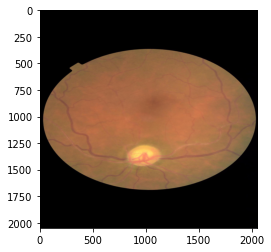

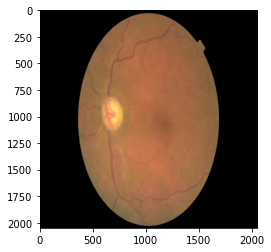

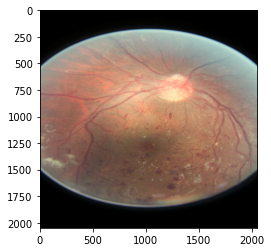

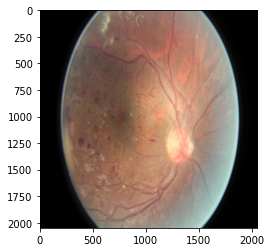

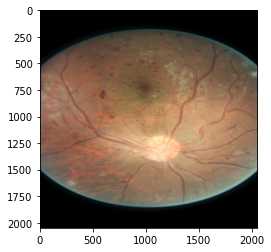

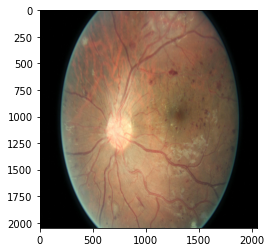

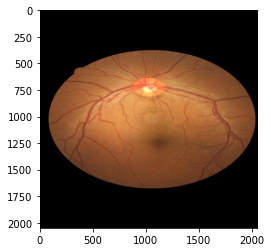

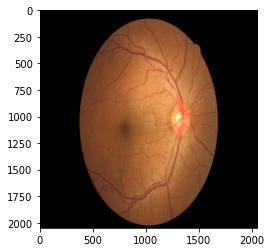

KeyboardInterrupt: ignored

In [ ]:
from csv import DictReader, DictWriter

field_names = ['image','level']
with open('/content/drive/MyDrive/Kaggle/train.csv', 'r') as read_obj:
    # pass the file object to reader() to get the reader object
    csv_reader = DictReader(read_obj)
    csv_writer = DictWriter(read_obj,fieldnames = field_names)
    # Iterate over each row in the csv using reader object
    for row in csv_reader:
        if(row['level']=='1' or row['level']=='3' or row['level']=='4'):
          path=f"/content/drive/MyDrive/Kaggle/train_images/"+row['image']+".jpeg"  #change to "/content/APTOS/train_images" if accessing from colab and "/content/drive/MyDrive/APTOS/train_images" if from drive
          image = io.imread(path)
          
          
          rotated1 = rotate(image, angle=90, mode = 'wrap')
          plot.imsave(f"/content/drive/MyDrive/Kaggle/train_images/"+row['image']+"rot.jpeg",rotated1)
          newrow = {'image':row['image']+"rot",'level':row['level']}
          dictwriter_object.writerow(newrow)
          
          rotated2 = rotate(image, angle=180, mode = 'wrap')
          plot.imsave(f"/content/drive/MyDrive/Kaggle/train_images/"+row['image']+"rot180.jpeg",rotated2)
          newrow = {'image':row['image']+"rot180",'level':row['level']}
          dictwriter_object.writerow(newrow)

          rotated3 = rotate(image, angle=270, mode = 'wrap')
          plot.imsave(f"/content/drive/MyDrive/Kaggle/train_images/"+row['image']+"rot270.jpeg",rotated3)
          newrow = {'image':row['image']+"rot270",'level':row['level']}
          dictwriter_object.writerow(newrow)

          flipUD = np.flipud(image)
          plot.imsave(f"/content/drive/MyDrive/Kaggle/train_images/"+row['image']+"UD.jpeg",flipUD)
          newrow = {'image':row['image']+"UD",'level':row['level']}
          dictwriter_object.writerow(newrow)

          flipLR = np.fliplr(image)
          plot.imsave(f"/content/drive/MyDrive/Kaggle/train_images/"+row['image']+"LR.jpeg",flipLR)
          newrow = {'image':row['image']+"LR",'level':row['level']}
          dictwriter_object.writerow(newrow)


    
    read_obj.close()


#Load/Build Model and Dataloader

In [ ]:
  def set_parameter_requires_grad(model, feature_extracting):
      if feature_extracting:
          for param in model.parameters():
              param.requires_grad = False

In [ ]:
class CreateDataset(Dataset):
    def __init__(self, df_data, data_dir = '../input/', transform=None):
        super().__init__()
        self.df = df_data.values
        self.data_dir = data_dir
        self.transform = transform

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        img_name,label = self.df[index]
        #img_path = os.path.join(self.data_dir, img_name+'.jpeg')
        img_path = os.path.join(self.data_dir, img_name+'.png')
        image = io.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
# Top level data directory. Here we assume the format of the directory conforms
#   to the ImageFolder structure
#data_dir = "/content/APTOS"
data_dir = "/content/drive/MyDrive/APTOS/"
#data_dir = "/content/drive/MyDrive/Kaggle/train_images"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "inception"

# Number of classes in the dataset
num_classes = 5

# Batch size for training (change depending on how much memory you have)
batch_size = 64

# Number of epochs to train for
num_epochs = 4

# Flag for feature extracting. When False, we finetune the whole model,
#   when True we only update the reshaped layer params
feature_extract = False     

inception = False



In [ ]:
#EraseReLU Inception
import sys
py_file_location = "/content/drive/MyDrive"
sys.path.append(os.path.abspath(py_file_location))
import InceptionEraseReLU as ER

In [ ]:
#Inception v3 EraseReLU Pretrained
model_ER = ER.inception_v3(pretrained=True)
set_parameter_requires_grad(model_ER, feature_extract)
# Handle the auxilary net
num_ftrs = model_ER.AuxLogits.fc.in_features
model_ER.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
# Handle the primary net
num_ftrs = model_ER.fc.in_features
model_ER.fc = nn.Linear(num_ftrs,num_classes)
input_size = 299
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#run if inceptionnet
model_ER.AuxLogits.fc = nn.Linear(768, num_classes)
model_ER.fc = nn.Linear(2048, num_classes)
# Send the model to GPU
model_ER = model_ER.to(device)
inception = True


Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [ ]:
#load EraseReLU Inception v3 model from drive
model_ER=ER.inception_v3()

set_parameter_requires_grad(model_ER, feature_extract)
# Handle the auxilary net
num_ftrs = model_ER.AuxLogits.fc.in_features
model_ER.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
# Handle the primary net
num_ftrs = model_ER.fc.in_features
model_ER.fc = nn.Linear(num_ftrs,num_classes)
input_size = 299

model_ER.load_state_dict(torch.load("/content/drive/MyDrive/APTOS/classifierERFT.pt"))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#run if inceptionnet
model_ER.AuxLogits.fc = nn.Linear(768, num_classes)
model_ER.fc = nn.Linear(2048, num_classes)
# Send the model to GPU
model_ER = model_ER.to(device)
inception = True



/content/drive/MyDrive/InceptionEraseReLU.py:85: FutureWarning: The default weight initialization of inception_v3 will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  ' due to scipy/scipy#11299), please set init_weights=True.', FutureWarning)


<All keys matched successfully>

In [ ]:
#EraseReLU Resnet
import sys
py_file_location = "/content/drive/MyDrive"
sys.path.append(os.path.abspath(py_file_location))
import ResnetEraseReLU as ER

In [ ]:
model_ER = models.resnet18(pretrained=True)
set_parameter_requires_grad(model_ER, feature_extract)
num_ftrs = model_ER.fc.in_features
model_ER.fc = nn.Linear(num_ftrs, num_classes)
input_size = 224
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_ER = model_ER.to(device)


Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:

model_ER.load_state_dict(torch.load("/content/drive/MyDrive/APTOS/RclassifierERFT.pt"))


<All keys matched successfully>

In [ ]:


# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ER.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ER.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ER.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Setup the loss function
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ER = SGD(params_to_update, lr=0.001, momentum=0.9)




In [ ]:

train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((input_size,input_size)),
    transforms.RandomHorizontalFlip(p=0.4),
    #transforms.ColorJitter(brightness=2, contrast=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
#why normalize? replicate preprocessing as on imagenet
#check if can extract green here
test_transforms = transforms.Compose([transforms.Resize(input_size),
                                      transforms.CenterCrop(input_size),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
train_path = "/content/drive/MyDrive/APTOS/train_images"
test_path = "/content/drive/MyDrive/APTOS/test_images"
train_data = CreateDataset(df_data=train, data_dir=train_path, transform=train_transforms)
test_data = CreateDataset(df_data=test, data_dir=test_path, transform=test_transforms)
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = DataLoader(train_data, batch_size=64,sampler=train_sampler)
validloader = DataLoader(train_data, batch_size=64, sampler=valid_sampler)
testloader = DataLoader(test_data, batch_size=64)

#dataloader_dict = {"train":trainloader,"val":validloader,"test":testloader}, when incorporated in test 
dataloader_dict = {"train":trainloader,"val":validloader}
  

In [ ]:
#Kaggle Drive
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((input_size,input_size)),
    transforms.RandomHorizontalFlip(p=0.4),
    #transforms.ColorJitter(brightness=2, contrast=2),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
])
#why normalize? replicate preprocessing as on imagenet
#check if can extract green here
#test_transforms = transforms.Compose([transforms.Resize(input_size),
#                                     transforms.CenterCrop(input_size),
#                                      transforms.ToTensor(),
#                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
train_path = "/content/drive/MyDrive/Kaggle/train_images"
#test_path = "/content/drive/MyDrive/APTOS/test_images"
train_data = CreateDataset(df_data=train, data_dir=train_path, transform=train_transforms)
#test_data = CreateDataset(df_data=test, data_dir=test_path, transform=test_transforms)
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

trainloader = DataLoader(train_data, batch_size=64,sampler=train_sampler)
validloader = DataLoader(train_data, batch_size=64, sampler=valid_sampler)
#testloader = DataLoader(test_data, batch_size=64)

#dataloader_dict = {"train":trainloader,"val":validloader,"test":testloader}, when incorporated in test 
dataloader_dict = {"train":trainloader,"val":validloader}
  

#Train Model

In [ ]:
#model training without scheduler
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            #for inputs, labels in tqdm(dataloaders[phase]):
            for inputs, labels in tqdm(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                        #print(loss)
 
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            #TBD save model somewhere, maybe drive
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [ ]:

# Train and evaluate
model_ER, hist = train_model(model_ER, dataloader_dict, criterion, optimizer_ER, num_epochs=num_epochs, is_inception=inception)


  0%|          | 0/46 [00:00<?, ?it/s]

Epoch 0/3
----------


  0%|          | 0/12 [00:00<?, ?it/s]

train Loss: 0.3979 Acc: 0.6565


 25%|██▌       | 3/12 [01:25<04:14, 28.29s/it]

FileNotFoundError: ignored

In [ ]:

#Save the model
#torch.save(model_ER.state_dict(),"/content/drive/MyDrive/APTOS/classifierER.pt")
#torch.save(model_ER.state_dict(),"/content/drive/MyDrive/Kaggle/IclassifierERFT.pt")
torch.save(model_ER.state_dict(),"/content/drive/MyDrive/Kaggle/RclassifierERFT.pt")

In [ ]:
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
classes = ["No DR", "Mild DR","Moderate DR","Severe DR" , "PDR"]

with torch.no_grad():
    for images , labels in validloader:
      

    #for data, dataLabel in testloader:
        #images, labels = testloader
        images = images.to(device)
        labels = labels.to(device)       
        outputs = model_ER(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(5):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

NameError: ignored